# Analyze background heat flow

Load background heat flow data from world heat flow database. Use kriging to make a map and calculate background heat flux for the Alps.

## Import modules:

In [67]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import pandas as pd
import geopandas as gp

import shapely
import rasterio as rio

import cartopy.crs as ccrs

#import pykrige.kriging_tools as kt
#from pykrige.ok import OrdinaryKriging

from lib.mapping_functions import *


## Define some variables:

In [68]:
fnb = 'GIS_data/outline_alps_final.shp'

fnr = 'GIS_data/gmted2010_alps_ll.tif'

hf_data_file = 'GIS_data/global_hf_eu_v3.csv'
hf_column = 'Heat Flow'
xcol = 'Longitude'
ycol = 'Latitude'

gradient_col = 'Gradient'

alps_bnd_buffer = 0.01

xmin, xmax, ymin, ymax = (4.0, 18.0, 42.75, 49.0)


vlims = [[25.0, 150.0], [10, 50.0]]
class_ints = [5.0, 2.5]
panel_labels = [['a', 'b'], ['c', 'd']]
zlabels = [r'Heat flow ($\times 10^{-3}$ W)', r'Geothermal gradient ($^\circ C \; km^{-1}$)']
#zlabels_short = ['heat flow', 'temp gradient']
fns_out = ['fig/background_heat_flow_map.png', 
           'fig/thermal_gradient_map.png']

#xmin, xmax, ymin, ymax = (4.0, 18.0, 42.75, 49.0)

cmap = matplotlib.cm.get_cmap('coolwarm')

proj = ccrs.PlateCarree()

fs_legend = 'small'
label_fs = 'medium'

legend_label = 'Data'
legend_label_nd = 'No data'

hist_ylabel = 'Number of\ndata points'

fn_out_merged = 'fig/combined_background_T_HF_map.png'


new db by Hasterok (unpublished:):
http://heatflow.org/

GIS version of global heat flow db:
http://datapages.com/gis-map-publishing-program/gis-open-files/global-framework/global-heat-flow-database

global hf database ihfc:
http://www.ihfc-iugg.org/products/global-heat-flow-database#mareschal_etal_2017

alternative link for ihfc db:
https://engineering.und.edu/research/global-heat-flow-database/

## Read the heat flow data

In [69]:
df = pd.read_csv(hf_data_file)

print('number of heat flow datapoints = %i' % (len(df)))

df.loc[df[hf_column]==0.0, hf_column] = np.nan

#df = df.dropna(subset=[hf_column])

print('number of heat flow datapoints = %i' % (len(df)))

df.head()

## clean DB from values outside EUR

ind = (df[ycol] < 30) | (df[xcol] < -5)
df = df.loc[ind==False]

print('number of heat flow datapoints = %i' % (len(df)))

#df = df.loc[df['heatflow_reliability']=='A']
#print('number of heat flow datapoints = %i' % (len(df)))


number of heat flow datapoints = 6807
number of heat flow datapoints = 6807
number of heat flow datapoints = 6534


In [70]:
df.head()

,OBJECTID,Data_Numbe,Codes,Site_Name,Latitude,Longitude,Elevation,minD,maxD,No__Temps,...,No__Cond_,Conductivi,No_Heat_Pr,Heat_Prod_,Heat Flow,No__sites,Year_of_Pu,Reference,Comments,Comments2
0,4397,4824,<null>,AINHICE,43.2133,-1.1317,220,0,3540,4,...,0,0.0,<null>,<null>,55.0,1,1991,Lucazeau_etal1991,Mottaghy_etal2005,conventional
1,4400,4825,<null>,Aire sur Adour,43.6783,-0.3083,160,0,4184,5,...,0,0.0,<null>,<null>,46.0,1,1991,Lucazeau_etal1991,Lucazeau_etal1991,borehole
2,4401,4826,<null>,ALBARON,43.5767,4.4300,524,0,270,1,...,0,0.0,<null>,<null>,144.0,1,1991,Lucazeau_etal1991,Lucazeau_etal1991,borehole
3,4403,4827,<null>,AMOU,43.6017,-0.7533,4,0,5542,8,...,0,0.0,<null>,<null>,73.0,1,1991,Lucazeau_etal1991,Lucazeau_etal1991,borehole
4,4406,4828,<null>,ANDOINS,43.3000,-0.2317,274,0,5563,4,...,0,0.0,<null>,<null>,77.0,1,1991,Lucazeau_etal1991,Lucazeau_etal1991,borehole


## Convert to geopandas dataframe for easier spatial processing

In [71]:
df['geometry'] = df.apply(lambda z: shapely.geometry.Point(z[xcol], z[ycol]), axis=1)
dg = gp.GeoDataFrame(df)

## Read shapefile with outline of the Alps

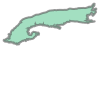

In [72]:
dgb = gp.read_file(fnb)
alps_poly = dgb.buffer(alps_bnd_buffer).geometry[0]

alps_poly

## Create cropped version of the heat flow db with pts only in the Alps

In [73]:
dga = dg.loc[dg.geometry.within(alps_poly)]
print('number of HF data in the Alps = %i' % (len((dga))))

number of HF data in the Alps = 231


## Load DEM

In [75]:
rf = rio.open(fnr)
dem = rf.read()[0]

dem = dem[::-1]

bounds = rf.bounds
xres, yres = rf.res

rf.close()

xcoords = np.arange(bounds.left + xres/2., bounds.right + xres/2., xres)
ycoords = np.arange(bounds.bottom + yres/2., bounds.top + yres/2., yres)
x_raster, y_raster = np.meshgrid(xcoords, ycoords)
res = 5
x_raster = x_raster[::res, ::res]
y_raster = y_raster[::res, ::res]
dem = dem[::res, ::res]

## Convert to UTM32N to calculate heat flow density

In [76]:
# UTM 32N = epsg: 32632

dgbu = dgb.to_crs({'init': 'epsg:32632'})
area_alps = dgbu.geometry.area[0]


## Organize data

In [77]:
z = dg[hf_column].values
x = dg[xcol].values
y = dg[ycol].values

sort_ind = np.argsort(z)

x = x[sort_ind]
y = y[sort_ind]
z = z[sort_ind]

ind_ok = (x >= xmin) & (x <=xmax) & (y >=ymin) & (y <= ymax)
x = x[ind_ok]
y = y[ind_ok]
z = z[ind_ok]

## Perform kriging for a heat flow map

## Use only values in the Alps

In [89]:
dgan = dga.dropna(subset=[hf_column])

za = dgan[hf_column].values
xa = dgan[xcol].values
ya = dgan[ycol].values

sort_ind = np.argsort(za)

xa = xa[sort_ind]
ya = ya[sort_ind]
za = za[sort_ind]

print('area Alps = %0.3f km2' % (area_alps/1e6))
area_one_datapoint = area_alps / len(za)
print('heat flow density = %0.2f km2 per hf datapoint' % (area_one_datapoint // 1e6))

radius = np.sqrt(area_one_datapoint / np.pi)

print('avg radius between hf datapoints = ', radius / 1e3)

area Alps = 202355.892 km2
heat flow density = 1117.00 km2 per hf datapoint
avg radius between hf datapoints =  18.864430715152263


In [90]:
# filter out alpensee data by Haenel 1971, erroneously indicated as borehole
# filter out shallow lake measurements:
ind = (dga['Comments2'] != 'lake (oceanic)') & (dga['Site_Name'] != 'Alpensee 1')

dgb = dga[ind]

dgb[gradient_col] = dgb[gradient_col].replace(0.000, np.nan)

dgb = dgb.dropna(subset=[gradient_col])

zb = dgb[gradient_col].values
xb = dgb[xcol].values
yb = dgb[ycol].values

sort_ind = np.argsort(zb)

xb = xb[sort_ind]
yb = yb[sort_ind]
zb = zb[sort_ind]

print('area Alps = %0.3f km2' % (area_alps/1e6))
print('n datapoints = %i' % (len(zb)))
area_one_datapoint = area_alps / len(zb)
print('heat flow density = %0.2f km2 per hf datapoint' % (area_one_datapoint // 1e6))

radius = np.sqrt(area_one_datapoint / np.pi)
print('avg radius between hf datapoints = ', radius / 1e3)

area Alps = 202355.892 km2
n datapoints = 19
heat flow density = 10650.00 km2 per hf datapoint
avg radius between hf datapoints =  58.22455670366476


/Users/elcopone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Load faults shapefile

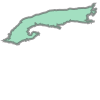

In [91]:
# load faults shapefile for background
shp_fns = ['GIS_data/faults_alcapadi.shp', 'GIS_data/outline_alps_final.shp']
shps = [gp.read_file(shp_fn) for shp_fn in shp_fns]

shp_colors = ['black', 'white']
shp_lss = ['-', '-']
shp_lws = [1.5, 0.75]

shps[-1].geometry.values[0]

calculating hillshade
creating color image
saving map as fig/background_heat_flow_map.png
done
calculating hillshade
creating color image
saving map as fig/thermal_gradient_map.png
done


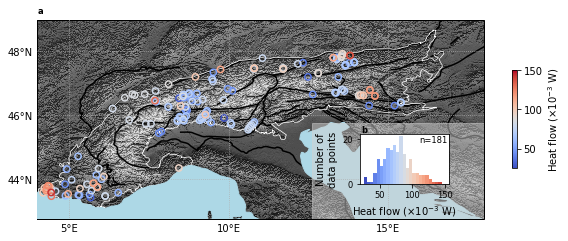

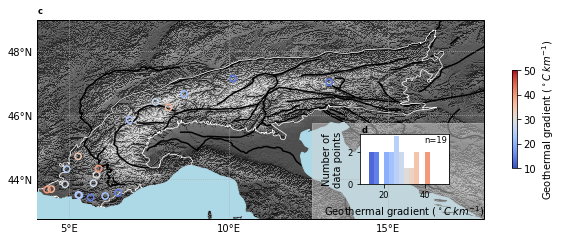

In [92]:
xs = [xa, xb]
ys = [ya, yb]
zs = [za, zb]

extent = xmin, xmax, ymin, ymax          

for xi, yi, zi, vlim, class_int, panel_label, zlabel, fn_out in zip(xs, ys, zs, 
                                                                    vlims, class_ints, panel_labels, 
                                                                    zlabels, fns_out):
    fig = make_map_figure(proj, extent, panel_label,
                          x_raster, y_raster, dem, 
                          xi, yi, zi, vlim, class_int,
                          zlabel, hist_ylabel, legend_label, legend_label_nd, 
                          shps, shp_colors, shp_lss, shp_lws, mark_highest_value=False)

    #fn_out = 'fig/background_heat_flow_map.png'
    print('saving map as %s' % fn_out)
    fig.savefig(fn_out, dpi=200)
    print('done')

## Merge two images

In [93]:
from PIL import Image

im1 = Image.open(fns_out[0])
im2 = Image.open(fns_out[1])

im1c = crop_img(im1)
im2c = crop_img(im2)

combined_img = get_concat_v(im1c, im2c)

print('saving combined figure as %s' % fn_out_merged)
combined_img.save(fn_out_merged)


saving combined figure as fig/combined_background_T_HF_map.png


## Some statistics on geothermal gradients & heat flow:

In [94]:
print('median heat flow = %0.3f' %(np.median(za)))
print('mean heat flow = %0.3f' %(np.mean(za)))
print('std heat flow = %0.3f' %(np.std(za)))


median heat flow = 75.000
mean heat flow = 76.773
std heat flow = 22.624


In [95]:

print('temp gradients, non-lake data:\n', dgb[gradient_col].describe())

print('HF, all data:\n', dga[hf_column].describe())

print('HF, non-lake data:\n', dgb[hf_column].describe())


temp gradients, non-lake data:
 count    19.000000
mean     26.210526
std       8.489071
min      14.000000
25%      21.500000
50%      25.000000
75%      32.000000
max      40.000000
Name: Gradient, dtype: float64
HF, all data:
 count    181.000000
mean      76.773481
std       22.686966
min       26.000000
25%       61.000000
50%       75.000000
75%       89.000000
max      144.000000
Name: Heat Flow, dtype: float64
HF, non-lake data:
 count     13.000000
mean      66.538462
std       21.132973
min       30.000000
25%       57.000000
50%       63.000000
75%       80.000000
max      117.000000
Name: Heat Flow, dtype: float64


In [96]:
dga.to_csv('data/background_heat_flow_alps.csv')